In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

# Malware Propagation Model

Density model:

$$ x \to x+1/N, N(1-x)(1+x) $$
$$ x \to x-1/N, Nx $$

No-density:

$$ X \to X+1, (1/N)(N-X)(N+X) $$
$$ x \to x-1, X $$

In [2]:
def rate1(X):
    rate = (1/N)*(N-X[0])*(N+X[0])
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
# Model Parameters
N=10
drift = [rate1, rate2]
S_matrix = np.array([[1], [-1]])  # Stoichiometry matrix
c = np.array([1, 1])  # Reaction rates
X0 = np.array([6])  # Initial state
T = 6  # Total time


## SSA

In [6]:
n_runs = 25000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_ssa = next_reaction(drift, S_matrix, c, X0, T)
    runs.append(X)
    
x_ssa = np.mean(np.array(runs), axis=0)

np.savetxt('X_SSA', x_ssa)
np.savetxt('T_SSA', t_ssa)

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed


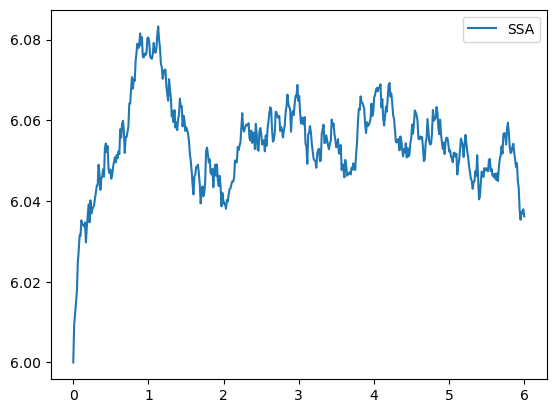

In [7]:
x_ssa = np.loadtxt('X_SSA')
t_ssa = np.loadtxt('T_SSA')

plt.plot(t_ssa, x_ssa, label='SSA')
plt.legend()



## Tau Leaping

In [8]:
tau = 0.05  # Leap size

n_runs = 25000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
       
print('Number of steps: ', len(X))

x_tau = np.mean(np.array(runs)[:,:,0], axis=0)

np.savetxt('X_tau', x_tau)
np.savetxt('T_tau', t_tau)

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Number of steps:  121


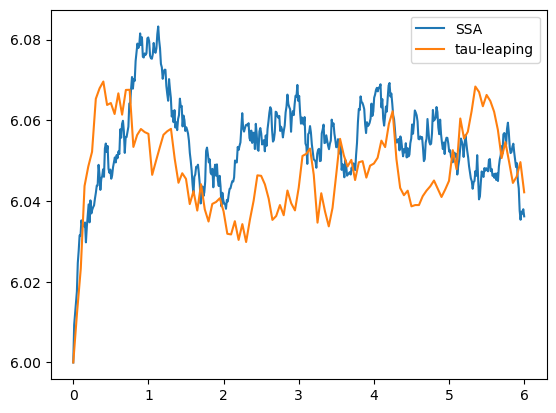

In [9]:
x_tau = np.loadtxt('X_tau')
t_tau = np.loadtxt('T_tau')

plt.plot(t_ssa, x_ssa, label='SSA')
plt.plot(t_tau, x_tau, label='tau-leaping')
plt.legend()

## Mean-field

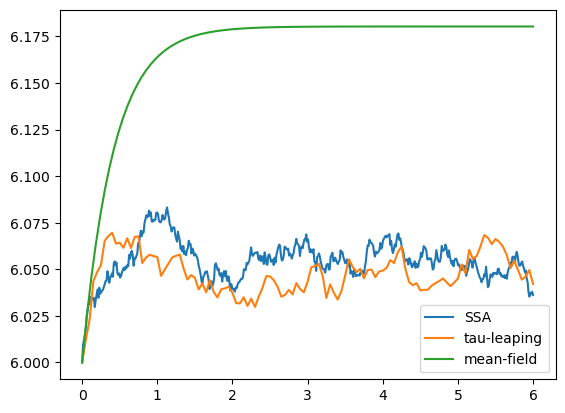

In [10]:
t_mf = np.linspace(0,T, 100)
x_mf = mean_field(drift,S_matrix,c,X0,t_mf)

plt.plot(t_ssa, x_ssa, label='SSA')
plt.plot(t_tau, x_tau, label='tau-leaping')
plt.plot(t_mf, x_mf[:,0], label='mean-field')
plt.legend()


## SOGA - Gaussian Approx.

In [11]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/MP10.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  pois_it[k_val] = 1 - norm.cdf(-muprime/pois_sigma)
C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  pois_it[k_val] = muprime*pois_it[k_val-1] + pois_sigma*norm.pdf(-muprime/pois_sigma)


Computed in 1.156s


In [12]:
x_soga = np.zeros(len(t_tau))
std_soga = np.zeros(len(t_tau))

for i in range(len(t_tau)):
    idx = output_dist.var_list.index('X[{}]'.format(i))
    x_soga[i] = output_dist.gm.mean()[idx]
    std_soga[i] = np.sqrt(output_dist.gm.cov()[idx,idx])

(5.8, 6.5)

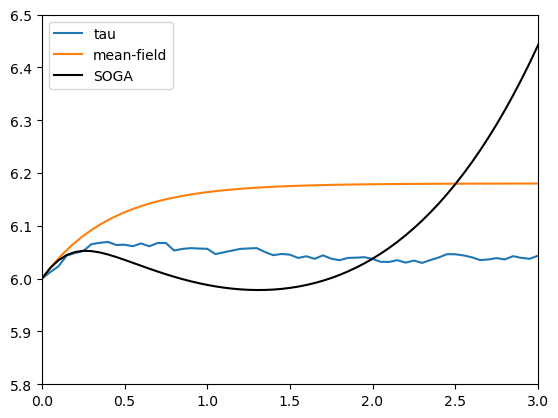

In [16]:
#plt.plot(t_ssa, x_ssa, label='SSA')
plt.plot(t_tau, x_tau, label='tau')
plt.plot(t_mf, x_mf[:,0], label='mean-field')
plt.plot(t_tau, x_soga, label='SOGA', color='black')
#plt.fill_between(t_tau, x_soga-std_soga, x_soga+std_soga ,alpha=0.3, color='green')
plt.legend()
plt.xlim(0,3)
plt.ylim(5.8,6.5)